## *Playing with real & fake news data from Kaggle*

<br>这里给出链接 [real & fake news dataset](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset)

<br><br>

### 查看数据内容，简单清理，并合并两个数据集

In [2]:
import numpy as np 
import pandas as pd 

real_path = './datasource/news/True.csv'
fake_path = './datasource/news/Fake.csv'

In [3]:
real_news = pd.read_csv(real_path)
real_news.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [33]:
real_news.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [34]:
real_news.subject.value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [4]:
real_news.text[1]

'WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administration’s request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on Jan. 1. A Justice Department official said the administration will not challenge those rulings. “The Department of Defense has announced that it will be releasing an independent study of these issues in the coming weeks. So rather than litigate this interim appeal before that occurs, the administration has decided to wait for DOD’s study and will continue to defend the president’s lawful authority in District Court in the meantime,” the official said, speaking on condition 

In [6]:
fake_news = pd.read_csv(fake_path)
fake_news.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [7]:
fake_news.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [8]:
fake_news.subject.value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [9]:
fake_news.text[1]

'House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys  don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known before that the former aide set up meetings with world leaders for Trump, but team Tr

两类news咋看上去数据内容都很完整（但其实不是），然后呢，虽然俩都分为四个属性，但内容方面稍有差异。比如fake news的主题(subject)种类更多，也就是说两个文件的主题标注方式并不对齐；real news在正文(text)的开始会标记信息来源如：WASHINGTON (Reuters) 华盛顿路透社，而fake news自然，没有标注相关来源，但我们主要还是应当从正文内容去捕捉两者差异。

In [5]:
# 移除RealNews中不必要的开头前缀，统一两种新闻的正文格式
import re 
def removePrefix(text):
    pattern = r"^([A-Z]).*?-\s"
    text = re.sub(pattern, '', text)
    return text

real_news.text = real_news.text.apply(lambda x : removePrefix(x))
real_news.text[1]

'Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administration’s request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on Jan. 1. A Justice Department official said the administration will not challenge those rulings. “The Department of Defense has announced that it will be releasing an independent study of these issues in the coming weeks. So rather than litigate this interim appeal before that occurs, the administration has decided to wait for DOD’s study and will continue to defend the president’s lawful authority in District Court in the meantime,” the official said, speaking on condition of anonymity. In Septem

In [7]:
# 打上标记
real_news['valid'] = 1
fake_news['valid'] = 0
# 合并数据集
news_source = pd.concat([real_news, fake_news], axis=0)
# 5789条在此三项内重复的数据
dup_news = news_source[news_source[['text', 'title', 'date']].duplicated() == True]
# 将它们去除
news_source = news_source[news_source[['text', 'title', 'date']].duplicated() == False]

In [8]:
# 重复条目数量
dup_news.count()

title      5789
text       5789
subject    5789
date       5789
valid      5789
dtype: int64

In [9]:
# 新闻内容中，有一些实际为空白（只含空格，不知道是咋回事，但反正不是nan）
news_source.text = news_source.text.apply(lambda x: np.nan if len(x.strip()) < 1 else x)
news_source.text.isna().sum()

447

In [10]:
# 放弃这部分数据
news_source = news_source.dropna()
# Subject主题两个数据集归类方式不统一，故删除
news_source.drop(columns=['subject'], inplace=True)
news_source.duplicated().sum()

0

In [11]:
# 剩余的两类目标总数目
news_source.valid.value_counts()

1    21198
0    17464
Name: valid, dtype: int64

In [12]:
# 保存合并，统一格式且清理后的数据集
news_source.to_csv('./datasource/news/Source.csv')

## 两类数据的一些特征分析
<br>
看一看两类数据内的一些特征的数据分布，相互之间会不会有较大差异

In [15]:
# 看看我们能不能从文本信息和其他维度中提取一些特征，做一点特种工程
# 查看两类新闻标题的用词频率
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import string

news_source = pd.read_csv('./datasource/news/Source.csv')
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

def word_count(df):
    word_cloud = WordCloud(max_words=50, background_color='white',stopwords=stop_words,colormap='rainbow',height=1000,width=700)
    news = df.text.values
    word_cloud.generate(str(news).lower())
    fig = plt.figure()
    plt.imshow(word_cloud)
    fig.set_figwidth(10)
    fig.set_figheight(10)
    plt.show()

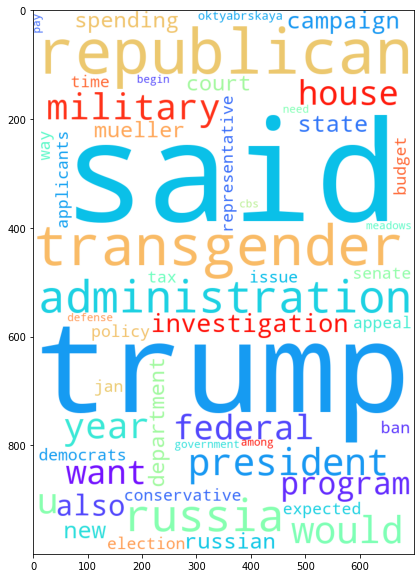

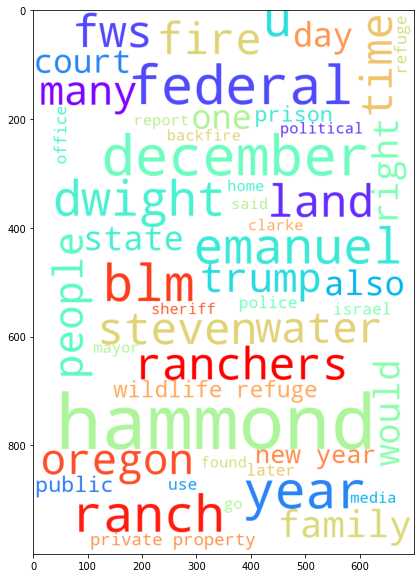

In [16]:
# real news中的高频词为
word_count(news_source[news_source.valid == 1])
# fake news则是
word_count(news_source[news_source.valid == 0])

看来真实新闻偏向于时政，以及当前执政党及其领导人所公布的信息<br>
虚假新闻则更喜欢一些当下矛盾相对尖锐的内容，不难理解，这部分内容更容易引起读者的注意力<br>
这么说来新闻主题/类别是非常有用的信息，可惜，此处两个数据集没能将fake与real两种新闻的主题利用同一种方式衡量标记<br>
那么在正文内容上，虚假新闻或许会用更多的遣词和手法来引起读者共鸣，看一看这种可能性是否存在

In [81]:
# 这类带有强烈感情色彩/导向的符号，两者之间是否会存在差异
def countPunctuation(text):
    ques = re.subn(r"\?", "", text)[1]
    exclam = re.subn(r"\!", "", text)[1]
    return ques, exclam

def textWordDiversity(df, valid):
    # 选中的部分独特单词数
    selected_df = df[df.valid == valid]
    selected_texts = ' '.join(selected_df.text.values).split()
    selected_unique = []
    for word in selected_texts:
        word = word.lower()
        if word not in selected_unique and word not in stop_words and word not in punctuations:
            selected_unique.append(word)
    # 全部数据的独特单词数
    texts = ' '.join(df.text.values).split()
    unique = []
    for word in texts:
        word = word.lower()
        if word not in unique and word not in stop_words and word not in punctuations:
            unique.append(word)
    # 在？看看用了多少种词
    return len(selected_unique) / len(unique)

In [80]:
# 来看看结果，要知道现在fake news在数据集中比real news少，两类数据并不是平衡的
news_source[['ques_num', 'exclam_num']] = news_source.text.apply(lambda x : pd.Series(countPunctuation(x)))
print("question marks in real news: ", news_source[news_source.valid == 1].ques_num.sum())
print("question marks in fake news: ", news_source[news_source.valid == 0].ques_num.sum())
print("exclamation marks in real news: ", news_source[news_source.valid == 1].exclam_num.sum())
print("exclamation marks in fake news: ", news_source[news_source.valid == 0].exclam_num.sum())

question marks in real news:  2127
question marks in fake news:  21534
exclamation marks in real news:  1303
exclamation marks in fake news:  12956


In [ ]:
# 实际上valid可是要比fake多出不少的，所以接下来的分析，各拿出一部分来进行（虽然拿的确实有点少）
partial_source = pd.concat([news_source.copy()[news_source.valid == 0][:100], news_source.copy()[news_source.valid == 1][:100]])

In [86]:
# 然后词频则是，嗯，是有些区别的，fake news的写作好像更自由一些？
print("lexical diversity of real news: ", textWordDiversity(partial_source, 1))
print("lexical diversity of fake news: ", textWordDiversity(partial_source, 0))

lexical diversity of real news:  0.5703858939153057
lexical diversity of fake news:  0.627908657320422


In [92]:
# 那么两者的标题和内容平均长度会差异巨大吗
partial_source['title_len'] = partial_source.title.apply(lambda x : len(x))
print("fake news avg title length :", partial_source[partial_source.valid == 0].title_len.sum() / partial_source[partial_source.valid == 0].valid.count())
print("real news avg title length :", partial_source[partial_source.valid == 1].title_len.sum() / partial_source[partial_source.valid == 1].valid.count())
partial_source['text_len'] = partial_source.text.apply(lambda x : len(x))
print("fake news avg text length :", partial_source[partial_source.valid == 0].text_len.sum() / partial_source[partial_source.valid == 0].valid.count())
print("real news avg text length :", partial_source[partial_source.valid == 1].text_len.sum() / partial_source[partial_source.valid == 1].valid.count())

fake news avg title length : 83.54
real news avg title length  : 62.59
fake news avg text length : 2533.92
real news avg text length  : 2594.39


In [13]:
# 然后来看看时间，虽然时间的标注方式并不对齐（部分月份为简写，部分未简写），但倒并不影响将其向datetime类型转化
# 然后呢，还有一部分奇奇怪怪的数据在date栏中记录了一个链接，好怪啊，rua。
news_source.date = news_source.date.apply(lambda x : pd.to_datetime(x) if len(x) < 20 else np.nan)

In [14]:
news_source = news_source.dropna()
news_source.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38656 entries, 0 to 38661
Data columns (total 5 columns):
Unnamed: 0    38656 non-null int64
title         38656 non-null object
text          38656 non-null object
date          38656 non-null datetime64[ns]
valid         38656 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 1.8+ MB


In [100]:
# 这个补0主要是让时间即使用string来排序，也能在正确的顺序上（2月不出现在10月后边）
def handelYearMonth(date):
    if date.month > 9:
        return str(date.year) + '-' + str(date.month)
    else:
        return str(date.year) + '-0' + str(date.month)
# 来看看时间上两种类型新闻的分布
fake_timedf = news_source[['valid', 'date']][news_source.valid == 0].copy()
real_timedf = news_source[['valid', 'date']][news_source.valid == 1].copy()
fake_timedf['year_mon'] = fake_timedf.date.apply(lambda x : handelYearMonth(x))
real_timedf['year_mon'] = real_timedf.date.apply(lambda x : handelYearMonth(x))
# 按照年-月进行统计
fake_timedf = fake_timedf.groupby(['year_mon']).valid.count()
real_timedf = real_timedf.groupby(['year_mon']).valid.count()

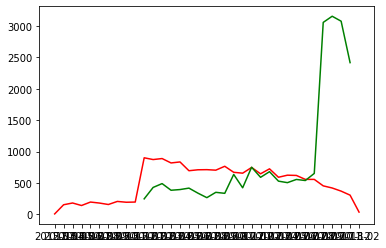

In [101]:
# real news的数量在2017年末呈现爆发性增长，fake news反而平稳，且在2017年末走低，是什么原因？
# 当然不排除是数据在各个时间点上统计量不一致才导致的现象，总之，此时把时间当作一个输入变量，可能不是什么好主意了（纵使部分新闻确实具有先后关系）
import matplotlib.pyplot as plt
plt.plot(fake_timedf.index, fake_timedf.values, color = 'red')
plt.plot(real_timedf.index, real_timedf.values, color = 'green')
plt.show()

现在可以公开的情报有：<br>
- 主题subject的标记标准没有对齐，难以将其作为feature使用
- date信息奇奇怪怪的，特别是2017年底real news大爆发，搞不清楚原因，但情理之中新闻数目应当是不会震荡的那么剧烈的，大概还是不把它当特征好些
- 正文text的长度，在采样中区别并没有很明显，但`title的平均长度`出现了明显差异，fake news似乎喜欢尝试往标题里塞入更多内容
- 用词种类上，fake news用词似乎更加自由，或许`正文的用词种类数`是一个不错的特征
- 当然，似乎用词类的overlap率不高？虽然没有利用nltk之类的工具去正经做tokenization，想看看时态之类的是否有明显差异，不过这个内容上的差异有些高过预期？
- 最明显的，fake news真的非常喜欢利用一些吸引人眼球的符号增强表述感情效果，至少`？和！的使用频率`明显大幅高于real news

### 利用观察所得结果，构建一些简单模型拟合看看

In [ ]:
# 利用特征工程来试试看一些简单模型
# 本机Scipy老报错，这部分就交给Kaggle了
from nltk.corpus import stopwords
import re
import string
import pandas as pd

news_source = pd.read_csv('./datasource/news/Source.csv')
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

In [ ]:
# real & fake news在各自正文与标题中最常用的单词表（top-10） 
def token_freq(df, feature, valid):
    tar_texts = df[df.valid == valid][feature].values
    texts = ' '.join(tar_texts).lower()
    tokens = ''.join(char for char in texts if char not in punctuations).split()
    tokens_cleaned = [word for word in tokens if word not in stop_words]
    return pd.DataFrame(nltk.FreqDist(tokens_cleaned).most_common(10))[0]

real_title_freq = token_freq(news_source, 'title', 1)
real_text_freq = token_freq(news_source, 'text', 1)
fake_title_freq = token_freq(news_source, 'title', 0)
fake_text_freq = token_freq(news_source, 'text', 0)

In [ ]:
# 每个news中各含多少高频词
def count_freq_token(text, freq_df):
    text = text.lower()
    tokens = ''.join(char for char in text if char not in punctuations).split()
    count = 0
    for token in tokens:
        if token in freq_df.values:
            count += 1
    return count

news_source['fake_title_token_freq'] = news_source.title.apply(lambda x : count_freq_token(x, fake_title_freq))
news_source['real_title_token_freq'] = news_source.title.apply(lambda x : count_freq_token(x, real_title_freq))
news_source['fake_text_token_freq'] = news_source.title.apply(lambda x : count_freq_token(x, fake_text_freq))
news_source['real_text_token_freq'] = news_source.title.apply(lambda x : count_freq_token(x, real_text_freq))

In [ ]:
# ？与！的使用频数统计
def countPunctuation(text):
    ques = re.subn(r"\?", "", text)[1]
    exclam = re.subn(r"\!", "", text)[1]
    return ques, exclam

news_source[['title_ques_num', 'title_exclam_num']] = news_source.title.apply(lambda x : pd.Series(countPunctuation(x)))
news_source[['text_ques_num', 'text_exclam_num']] = news_source.text.apply(lambda x : pd.Series(countPunctuation(x)))

In [ ]:
# 标题长度与标题-正文长度比例
news_source['title_len'] = news_source.title.apply(lambda x : len(x))
news_source['title_ratio'] = news_source.text.apply(lambda x : len(x))
news_source['title_ratio'] = news_source['title_len'] / news_source['title_ratio']

In [ ]:
# 保存一下
news_source.to_csv('./datasource/news/NewsAna.csv')
news_source.corr().valid

In [ ]:
import pandas as pd 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
# 去除不需要的列，并打乱数据顺序
news_source = pd.read_scv('./datasource/news/NewsAna.csv')
news_source.drop(columns=['Unnamed: 0', 'title', 'text', 'date'], inplace=True)
news_source.reset_index()
news_source = news_source.sample(frac=1)
# 终于能直接快速分测试训练集了，本来分析应当只基于训练集来着
train_set, test_set = train_test_split(news_source, test_size=0.2, random_state=7)
train_x = train_set[['fake_title_token_freq', 'real_title_token_freq', 'fake_text_token_freq', 
                 'real_text_token_freq', 'title_ques_num', 'title_exclam_num', 'text_ques_num', 
                 'text_exclam_num', 'title_len', 'title_ratio']]
train_y = train_set['valid']
test_x = test_set[['fake_title_token_freq', 'real_title_token_freq', 'fake_text_token_freq', 
                 'real_text_token_freq', 'title_ques_num', 'title_exclam_num', 'text_ques_num', 
                 'text_exclam_num', 'title_len', 'title_ratio']]
test_y = test_set['valid']

In [ ]:
def model_report(model, tar_x, tar_y):
    pred = model.predict(tar_x)
    f1 = f1_score(tar_y, pred)
    print("f1-score: ", f1)
    acc = accuracy_score(tar_y, pred)
    print("accuracy: ", acc)
    cm = confusion_matrix(tar_y, pred)
    print("confusion matrix:\n",cm)

In [ ]:
randomForest = RandomForestClassifier(random_state=7)
randomForest.fit(train_x, train_y)

In [ ]:
print("RF on training set:")
model_report(randomForest, train_x, train_y)
print("\nRF on testing set:")
model_report(randomForest, test_x, test_y)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decisionTree = DecisionTreeClassifier()
decisionTree.fit(train_x, train_y)

In [ ]:
print("tree on training set:")
model_report(decisionTree, train_x, train_y)
print("\ntree on testing set:")
model_report(decisionTree, test_x, test_y)

In [ ]:
from sklearn.svm import LinearSVC

linearSVC = LinearSVC(max_iter=8000, penalty='l2')
linearSVC.fit(train_x, train_y)

In [ ]:
print("LinearSVC on training set:")
model_report(linearSVC, train_x, train_y)
print("\nLinearSVC on testing set:")
model_report(linearSVC, test_x, test_y)

### Mess Around，用BERT模型根据title来玩玩看吧

In [1]:
# 但是不管怎么样，说到NLP，总归得试试看BERT
# 虽然说这确实有些mess around
# 这东西太大了，单纯用title来跑一下看看吧
from transformers import AutoModel, AutoConfig, AutoTokenizer, AdamW
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler
import torch

import pandas as pd
news_source = pd.read_csv('./datasource/news/Source.csv')

batch_size = 32
epoch_num = 10
max_seq_length = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model_path = "E:/PreTrainedModels/Huggingface/bert-base-uncased"

In [2]:
class NewsModel(torch.nn.Module):
    def __init__(self, bert_model=bert_model_path, add_feature_num=0):
        super(NewsModel, self).__init__()
        # 加载预训练模型(from huggingface)
        self.bert_layer = AutoModel.from_pretrained(pretrained_model_name_or_path=bert_model)
        # 或许可以补入一点特征数据，来求取最终结果
        self.bert_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=bert_model)
        self.mid_dim = self.bert_config.hidden_size + add_feature_num
        # 进行最终分类
        self.output = torch.nn.Sequential(
            torch.nn.Linear(self.mid_dim, self.mid_dim//2),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(self.mid_dim//2, self.mid_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(self.mid_dim, num_class),
            torch.nn.Sigmoid()
        )
    def forward(self, input_ids, attn_mask=None, add_features=[]):
        bert_out = self.bert_layer(input_ids=input_ids, attention_mask=attn_mask)[1]
        # 加入特征也应当为：[batch_size, add_feature_num]的形状
        if len(add_features) > 0:
            add_features = torch.tensor(add_features, dtype=torch.float)
            if add_features.shape[0] == bert_out.shape[0]:
                bert_out = torch.cat(bert_out, add_features)
        output = self.output(bert_out)
        return output

In [13]:
# 准备输入，获取Attention masks和input ids
def covertTokenFormat(df, bert_model_path, max_seq_len):
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=bert_model_path)
    titles = df.title.tolist()
    title_tokens = tokenizer(titles, padding='max_length', max_length=max_seq_len, truncation=True, return_tensors="pt")
    labels = torch.tensor(df.valid.values, dtype=torch.float)
    return title_tokens, labels

In [ ]:
news_model = NewsModel(bert_model=bert_model_path)
news_model = news_model.to(device)
optimiser = AdamW(news_model.parameters(), lr=1e-5)
# 要是本地的Scipy不搁那儿报错，还能分一下测试集或者加入K-Fold的，害
title_tokens, labels = covertTokenFormat(news_source, bert_model_path, max_seq_length)
train_data = TensorDataset(title_tokens.input_ids, title_tokens.attention_mask, labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [ ]:
# 按常理来说，跑不完，会吃掉12G左右显存（GPU下）
news_model.train()
for epoch in range(epoch_num):
    epoch_loss = 0
    for batch, (token_ids, attn_mask, label) in enumerate(train_dataloader):
        # 保证在同一硬设备中运算
        token_ids = token_ids.to(device)
        attn_mask = attn_mask.to(device)
        label = label.to(device)
        # 注意output也在指定的device中，loss也是
        outputs = news_model(token_ids, attn_mask)
        loss = F.binary_cross_entropy(outputs.squeeze(), label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 所以把loss扔回CPU中计算结果
        epoch_loss += loss.cpu().data.numpy()
        print("Current batch loss :", loss.cpu().data.numpy())
    print("Now epoch :", epoch, " Total epoch loss is: ", epoch_loss)

### BERT玩这个太大了，LSTM处理一下试试看好了

In [1]:
# 虽然这个模型也说不上很小，试试看用GRU吧
# 词向量就直接用glove的预训练结果吧
import torch
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from torchtext.vocab import GloVe

import pandas as pd
news_source = pd.read_csv('./datasource/news/Source.csv')

stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)
cache_dir = './datasource/news/glove'
glove = GloVe(name='6B', dim=50, cache=cache_dir)

epoch_num = 50
batch_size = 64
lr = .001
input_dim = 50
output_dim = 1
gru_num_layers = 2

In [2]:
# 嘛，从之前写的ipybn里随手拿了个模型修修补补
class NewsGRUModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim, gru_num_layers=1, bidirectional=False, dropout=.3, hidden_layers = [128, 64, 128]):
        super(NewsGRUModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = input_dim // 2 if bidirectional else input_dim
        self.output_dim = output_dim
        self.gru_num_layers = gru_num_layers
        # GRUs
        self.gru_layer = torch.nn.GRU(
            input_size=self.input_dim, 
            hidden_size=self.hidden_dim, 
            num_layers=self.gru_num_layers, 
            bidirectional=bidirectional, 
            batch_first=True,
            dropout=dropout
        )
        # The FFN to adjust the outputs
        if hidden_layers and not len(hidden_layers) == 0:
            # the dim is not changed through the two GRU layer
            hidden_list = [torch.nn.Linear(self.input_dim, hidden_layers[0])]
            for idx in range(len(hidden_layers) - 1):
                hidden_list.append(torch.nn.Linear(hidden_layers[idx], hidden_layers[idx + 1]))
            self.hidden_layer_list = torch.nn.ModuleList(hidden_list)
            # init the weights
            for layer in self.hidden_layer_list: 
                torch.nn.init.kaiming_normal_(layer.weight.data)
            self.hidden_out_dim = hidden_layers[-1]
        else:
            self.hidden_layer_list = []
            self.hidden_out_dim = self.input_dim
        # Output layer
        self.output = torch.nn.Linear(self.hidden_out_dim, self.output_dim)
        torch.nn.init.kaiming_normal_(self.output.weight.data)
        # Other functions
        self.activate = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(dropout)
    
    def forward(self, x):
        # GRU layer
        output, hidden_info = self.gru_layer(x)
        output = self.activate(output[:, -1].unsqueeze(0))
        output = self.dropout(output)
        # ffn process
        for layer in self.hidden_layer_list:
            output = layer(output)
            output = self.activate(output)
            output = self.dropout(output)
        # output layer, get logits
        output = self.output(output)
        return output

In [3]:
# 将句子转化为tokens，用了Glove的预训练词向量
def covertTextToGolveVec(df):
    golve_vecs = []
    titles = df.title.values
    for title in titles:
        tokens = word_tokenize(title.lower())
        for token in tokens:
            if token in stop_words or token in punctuations:
                tokens.remove(token)
        golve_vecs.append(glove.get_vecs_by_tokens(tokens))
    return golve_vecs

In [5]:
# 没通过限制max seq length来padding句子，没法stack成一个Tensor用RandomSampler了
# 这挺糟糕的，能pad还是得设一个max_seq_len去pad一下
title_list = covertTextToGolveVec(news_source)
label_list = torch.Tensor(news_source.valid.values)
sample_num = news_source.valid.count()

news_gru = NewsGRUModel(input_dim=input_dim, output_dim=output_dim, gru_num_layers=gru_num_layers)
optimiser = torch.optim.RMSprop(news_gru.parameters(), lr=lr)
loss_func = torch.nn.MSELoss()
batch_num = (sample_num // batch_size) + 1

In [ ]:
# 手动批训练吧，不过这破笔记本cpu，是跑不完的（指出
news_gru.train()
for epoch in range(epoch_num):
    epoch_loss = 0
    for batch_idx in range(batch_num):
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size if start_idx + batch_size <= sample_num else -1
        batch_pred = []
        for sample in title_list[start_idx : end_idx]:
            batch_pred.append(news_gru(sample.unsqueeze(0)))
        batch_pred = torch.stack(batch_pred).squeeze()
        loss = loss_func(batch_pred, label_list[start_idx : end_idx])
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        epoch_loss += loss
    print("Current epoch: ", epoch, " Total loss: ", epoch_loss)

In [20]:
# 不过不管怎么着总也得跑一段看看
news_gru.train()
for batch_idx in range(30):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size if start_idx + batch_size <= sample_num else -1
    batch_pred = []
    for sample in title_list[start_idx : end_idx]:
        batch_pred.append(news_gru(sample.unsqueeze(0)))
    batch_pred = torch.stack(batch_pred).squeeze()
    loss = loss_func(batch_pred, label_list[start_idx : end_idx])
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    print("Current loss: ", loss.data.numpy())

Current loss:  0.010390416
Current loss:  0.007965839
Current loss:  0.0089618275
Current loss:  0.013991668
Current loss:  0.01069735
Current loss:  0.007174591
Current loss:  0.013476979
Current loss:  0.009348544
Current loss:  0.0052419463
Current loss:  0.007009668
Current loss:  0.015509825
Current loss:  0.010282484
Current loss:  0.012670263
Current loss:  0.015222164
Current loss:  0.008692235
Current loss:  0.010995034
Current loss:  0.008002712
Current loss:  0.0072150803
Current loss:  0.006666762
Current loss:  0.010235922
Current loss:  0.008369005
Current loss:  0.008445826
Current loss:  0.007906225
Current loss:  0.008434954
Current loss:  0.011205854
Current loss:  0.010293592
Current loss:  0.012121465
Current loss:  0.00932969
Current loss:  0.013033342
Current loss:  0.008301216
